In [156]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [658]:
df = pd.read_csv(drive_dir + 'model_df10.csv')
df = df.fillna(0)
#df = df.replace([np.inf, -np.inf], 100000)

In [659]:
df = df[df['home_team_season_game_num'] > 3]
#df = df[df['M'] <10]

In [660]:
df.head()

,date,Y,M,D,home_team,away_team,home_win,home_pitcher,away_pitcher,home_elo,away_elo,home_avg,away_avg,home_obp,away_obp,home_slg,away_slg,home_iso,away_iso,elo_diff,elo_pct_diff,avg_diff,obp_diff,slg_diff,avg_pct_diff,obp_pct_diff,slg_pct_diff,home_rest,away_rest,away_team_season_game_num,home_team_season_game_num,home_ERA_offset1year,home_WHIP_offset1year,away_ERA_offset1year,away_WHIP_offset1year,home_W-L-pct_offset1year,home_Avg_Attendance_offset1year,home_R_offset1year,home_RA_offset1year,home_Rank_offset1year,home_FP_offset1year,away_W-L-pct_offset1year,away_Avg_Attendance_offset1year,away_R_offset1year,away_RA_offset1year,away_Rank_offset1year,away_FP_offset1year,pitcher_home_ERA_offset1game,pitcher_home_WHIP_offset1game,pitcher_home_IP_offset1game,pitcher_home_aLI_offset1game,pitcher_home_WPA_offset1game,pitcher_away_ERA_offset1game,pitcher_away_WHIP_offset1game,pitcher_away_IP_offset1game,pitcher_away_aLI_offset1game,pitcher_away_WPA_offset1game,home_ops,away_ops,home_RD,away_RD,pitcher_WHIP_diff,pitcher_ERA_diff,pitcher_IP_diff,W-L_diff,ops_diff,RD_diff,FP_diff,Rank_diff,WPA_diff,aLI_diff,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,ops_pct_diff,RD_pct_diff,FP_pct_diff,Rank_pct_diff,WPA_pct_diff,aLI_pct_diff
59,2001-04-06,2001,4.0,6.0,LAN,SFN,1.0,prokolu01,estessh01,1514.056,1545.219,0.254198,0.276079,0.336984,0.359380,0.426431,0.468525,0.172233,0.192446,-31.163,-2.058246,-0.021882,-0.022396,-0.042094,-8.608121,-6.645941,-9.871337,1.0,1.0,0,4,4.10,1.369550,4.21,1.436881,0.530864,35699.943750,798.0,729.0,2.0,0.978,0.598765,36484.765432,925.0,747.0,1.0,0.985,0.0,0.0,0.0,0.00,0.000,0.00,0.000000,0.0,0.00,0.000,0.763415,0.827905,69.0,178.0,0.000000,0.00,0.0,-0.067901,-0.064490,-109.0,-0.007,1.0,0.000,0.00,0.000000,0.000000,0.0,-8.447593,-157.971014,-0.715746,50.000000,0.00000,0.0
61,2001-04-07,2001,4.0,7.0,LAN,SFN,1.0,parkch01,hernali01,1518.394,1540.881,0.254198,0.276079,0.336984,0.359380,0.426431,0.468525,0.172233,0.192446,-22.487,-1.480973,-0.021882,-0.022396,-0.042094,-8.608121,-6.645941,-9.871337,1.0,1.0,1,5,4.10,1.369550,4.21,1.436881,0.530864,35699.943750,798.0,729.0,2.0,0.978,0.598765,36484.765432,925.0,747.0,1.0,0.985,0.0,1.0,7.0,1.26,0.445,0.00,0.000000,0.0,0.00,0.000,0.763415,0.827905,69.0,178.0,0.000000,0.00,0.0,-0.067901,-0.064490,-109.0,-0.007,1.0,0.000,0.00,0.000000,0.000000,0.0,-8.447593,-157.971014,-0.715746,50.000000,0.00000,0.0
66,2001-04-07,2001,4.0,7.0,MIA,ATL,1.0,dempsry01,burkejo03,1478.121,1525.134,0.258568,0.268227,0.327653,0.342770,0.404271,0.423582,0.145703,0.155356,-47.013,-3.180592,-0.009659,-0.015118,-0.019312,-3.735467,-4.613904,-4.776941,1.0,1.0,2,4,4.59,1.488245,4.06,1.327686,0.490683,22040.418750,731.0,797.0,3.0,0.980,0.586420,35842.962733,810.0,714.0,1.0,0.979,5.4,1.6,5.0,0.88,-0.218,6.35,1.346154,5.2,1.01,-0.184,0.731923,0.766353,-66.0,96.0,0.253846,-0.95,-0.2,-0.095737,-0.034429,-162.0,0.001,2.0,-0.034,-0.13,15.865381,-17.592593,-4.0,-4.703953,245.454545,0.102041,66.666667,15.59633,-101.0
68,2001-04-07,2001,4.0,7.0,NYA,TOR,0.0,hernaor01,michach01,1530.010,1510.912,0.275080,0.273459,0.351633,0.339283,0.446269,0.466387,0.171189,0.192927,19.098,1.248227,0.001621,0.012350,-0.020117,0.589262,3.512146,-4.507899,1.0,1.0,4,4,4.76,1.428973,5.17,1.513465,0.540373,37914.055901,871.0,814.0,1.0,0.981,0.512346,24861.419753,861.0,908.0,3.0,0.984,0.0,0.0,0.0,0.00,0.000,0.00,0.000000,0.0,0.00,0.000,0.797902,0.805669,57.0,-47.0,0.000000,0.00,0.0,0.028027,-0.007768,104.0,-0.003,-2.0,0.000,0.00,0.000000,0.000000,0.0,-0.973496,182.456140,-0.305810,-200.000000,0.00000,0.0
70,2001-04-07,2001,4.0,7.0,HOU,PIT,0.0,botteke01,arroybr01,1517.760,1479.484,0.274747,0.264954,0.357254,0.336220,0.471121,0.420830,0.196375,0.155876,38.276,2.521874,0.009792,0.021033,0.050291,3.564191,5.887504,10.674739,1.0,1.0,4,4,5.42,1.526579,4.94,1.563147,0.444444,34178.478261,938.0,944.0,4.0,0.978,0.425926,26443.132075,793.0,888.0,5.0,0.979,0.0,0.0,0.0,0.00,0.000,0.00,0.000000,0.0,0.00,0.000,0.828375,0.757051,-6.0,-

In [661]:
df['pitcher_WHIP_pct_diff'].isnull().sum() / df['pitcher_WHIP_pct_diff'].shape[0]

0.0

In [662]:
df[df['pitcher_WHIP_pct_diff'].isin([np.inf, -np.inf])].shape

(17, 80)

In [ ]:
c = 0
for col in df.columns:
  print(df[df[col].isin([np.inf, -np.inf])].shape[0])

In [159]:
df.columns

Index(['date', 'Y', 'M', 'D', 'home_team', 'away_team', 'home_win',
       'home_pitcher', 'away_pitcher', 'home_elo', 'away_elo', 'home_avg',
       'away_avg', 'home_obp', 'away_obp', 'home_slg', 'away_slg', 'home_iso',
       'away_iso', 'elo_diff', 'elo_pct_diff', 'avg_diff', 'obp_diff',
       'slg_diff', 'avg_pct_diff', 'obp_pct_diff', 'slg_pct_diff', 'home_rest',
       'away_rest', 'away_team_season_game_num', 'home_team_season_game_num',
       'home_Avg_Attendance_offset1year', 'home_W-L-pct_offset1year',
       'home_Rank_offset1year', 'home_R_offset1year', 'home_RA_offset1year',
       'home_FP_offset1year', 'away_Avg_Attendance_offset1year',
       'away_W-L-pct_offset1year', 'away_Rank_offset1year',
       'away_R_offset1year', 'away_RA_offset1year', 'away_FP_offset1year',
       'home_WHIP_offset1year', 'home_ERA_offset1year',
       'away_WHIP_offset1year', 'away_ERA_offset1year',
       'pitcher_home_WHIP_offset1game', 'pitcher_home_ERA_offset1game',
       'pitcher_ho

In [663]:
df['home_win'] = df['home_win'].astype(int)

In [664]:
df = df[[ 'Y', 'M', 'home_win', 'avg_pct_diff', #'obp_pct_diff', 'slg_pct_diff', 
       #'home_Avg_Attendance_offset1year',  'away_Avg_Attendance_offset1year',
        'pitcher_WHIP_pct_diff',
       'pitcher_ERA_pct_diff',# 'pitcher_IP_pct_diff', 
       'ops_pct_diff',
       'RD_pct_diff', 
       #'FP_pct_diff',
        'Rank_pct_diff', 'WPA_pct_diff',# 'avg_diff', 'obp_diff',
       'slg_diff','pitcher_WHIP_diff',
       'pitcher_ERA_diff', 'pitcher_IP_diff', 'W-L_diff', 'ops_diff',
       'RD_diff', #'FP_diff', 
       'Rank_diff', 'WPA_diff',]]#'aLI_pct_diff']],# 'aLI_diff']]'aLI_pct_diff'

In [665]:
train = df[df['Y'] <= 2015]
test = df[df['Y'] > 2015]

In [666]:
train = train.drop('Y', axis=1)
test= test.drop('Y', axis=1)

In [667]:
X_train = train.drop('home_win', axis=1)
y_train = train.home_win
X_test = test.drop('home_win', axis=1)
y_test = test.home_win

In [668]:
model = xgb.XGBClassifier()
xgb_model = model.fit(X_train, y_train)

In [669]:
preds = xgb_model.predict(X_test)

In [670]:
accuracy_score(y_test, preds)

0.6293570036804503

In [654]:
model = xgb.XGBClassifier(max_depth=3, learning_rate=0.03, n_estimators=500, )# importance_type='total_gain')
xgb_m = model.fit(X_train, y_train)

In [671]:
import joblib

#joblib.dump(xgb_model, drive_dir + 'xgb_baseball_model.joblib') 

['/content/drive/My Drive/xgb_baseball_model.joblib']

In [656]:
preds = xgb_m.predict(X_test)

In [657]:
accuracy_score(y_test, preds)

0.6278415241394241

In [552]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.53      0.57      3344
           1       0.63      0.71      0.67      3854

    accuracy                           0.63      7198
   macro avg       0.62      0.62      0.62      7198
weighted avg       0.63      0.63      0.62      7198



In [572]:
featuredf = pd.DataFrame(xgb_m.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

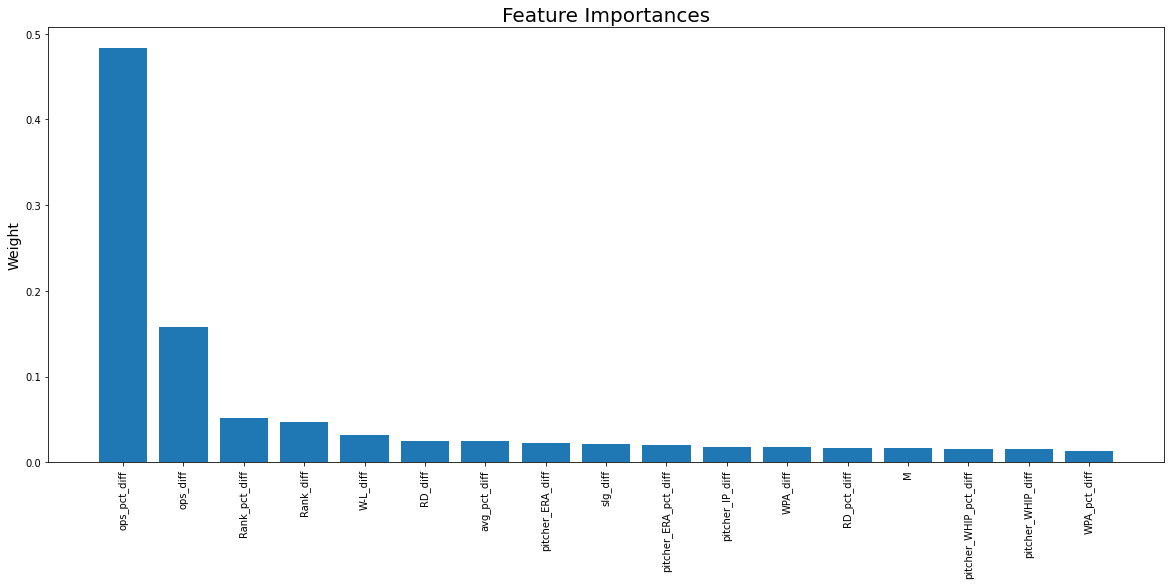

In [573]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
#plt.xticks([0,1,2,3,4,5,6,7,8], ['OBP', 'ISO', 'WHIP', 'K/BB', 'FIP', 'K/9', 'ELO', 'HR/9', 'Rest Days'])
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14)
plt.savefig(drive_dir + 'feature_importance.png');

In [440]:
monthly_acc = []
months_list = np.sort(X_test['M'].unique())
for months in months_list:
  test_month = test[test['M'] == months]

  X_test_month = test_month.drop('home_win', axis=1)
  y_test_month = test_month.home_win

  pred = xgb_m.predict(X_test_month)
  acc = accuracy_score(y_test_month, pred)

  monthly_acc.append(acc)

monthly_acc = pd.DataFrame(monthly_acc)

In [441]:
monthly_acc

,0
0,0.454545
1,0.614089
2,0.634409
3,0.646296
4,0.641711
5,0.605122
6,0.624769


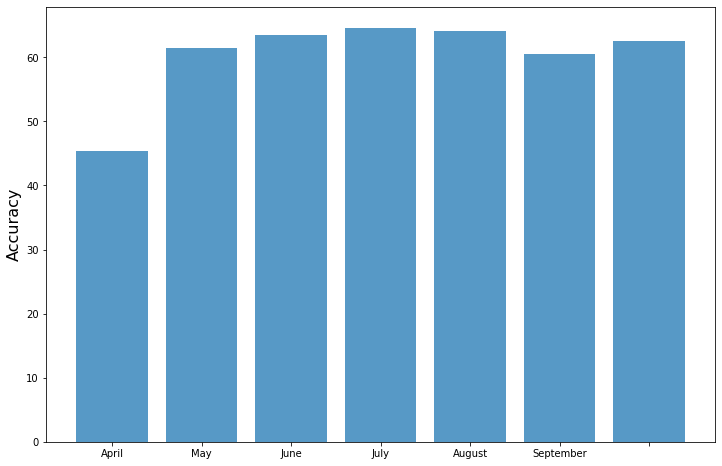

In [442]:
plt.figure(figsize=(12,8))
plt.bar(monthly_acc.index, monthly_acc[0]*100, alpha=0.75)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks([0,1,2,3,4,5,6,], ['April', 'May', 'June','July', 'August', 'September']);

In [ ]:
X_train = X_train.replace([np.inf, -np.inf], 1000)
X_test = X_test.replace([np.inf, -np.inf], 1000)

In [ ]:
rfc = RandomForestClassifier(criterion='entropy', n_estimators=60, max_depth=4)
forest_model = rfc.fit(X_train, y_train)

In [ ]:
rfc_preds = rfc.predict(X_test)

In [ ]:
accuracy_score(y_test, rfc_preds)

0.6230705906565137

In [ ]:
dtc = DecisionTreeClassifier(criterion='entropy', max_features=None, max_depth=3)
tree_model = dtc.fit(X_train, y_train)

In [ ]:
dtc_preds = dtc.predict(X_test)

In [ ]:
accuracy_score(y_test, dtc_preds)

0.6194690265486725

In [ ]:
predictions = []
for i in range(y_test.shape[0]):
  p = preds[i] + rfc_preds[i] +dtc_preds[i]


  if p >= 3:
    predictions.append(1)
  else:
    predictions.append(0)

In [ ]:
accuracy_score(y_test, predictions)

0.6257460382794814

In [ ]:
!pip install interpret

     |████████████████████████████████| 5.2MB 20.8MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 1.8MB 40.6MB/s 
     |████████████████████████████████| 3.6MB 45.8MB/s 
     |████████████████████████████████| 5.3MB 31.6MB/s 
     |████████████████████████████████| 471kB 54.1MB/s 
     |████████████████████████████████| 276kB 54.3MB/s 
     |████████████████████████████████| 788kB 46.1MB/s 
     |████████████████████████████████| 122kB 59.6MB/s 
     |████████████████████████████████| 860kB 46.4MB/s 
     |████████████████████████████████| 327kB 55.4MB/s 
     |████████████████████████████████| 1.0MB 40.9MB/s 
     |████████████████████████████████| 3.5MB 47.5MB/s 
     |████████████████████████████████| 194kB 49.1MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 245kB 48.5MB/s 
     |████████████████████████████████| 358kB 54.2MB/s 
     |████████████████████████████████| 358kB 47.3M

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['M', 'avg_pct_diff',
                                             'obp_pct_diff', 'slg_pct_diff',
                                             'home_Avg_Attendance_offset1year',
                                             'away_Avg_Attendance_offset1year',
                                             'pitcher_WHIP_pct_diff',
                                             'pitcher_ERA_pct_diff',
                                             'pitcher_IP_pct_diff',
                                             'ops_pct_diff', 'RD_pct_diff',
                                             'FP_pct_diff',...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'contin

In [ ]:
emb_preds = ebm.predict(X_test)

In [ ]:
accuracy_score(y_test, emb_preds)

0.6221444741716402

In [ ]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

In [ ]:
ebm_test = X_test[1000:1010]
emb_test_labels = y_test[1000:1010]

In [ ]:
ebm_local = ebm.explain_local(ebm_test, emb_test_labels)
show(ebm_local)

In [ ]:
X_test[1000:1010]

,M,avg_pct_diff,obp_pct_diff,slg_pct_diff,home_Avg_Attendance_offset1year,away_Avg_Attendance_offset1year,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,ops_pct_diff,RD_pct_diff,FP_pct_diff,Rank_pct_diff,WPA_pct_diff
37443,6.0,-38.371796,-40.956375,-44.387960,29223.144654,31175.968750,0.000000,0.000000,0.000000,-43.043325,-1005.000000,0.202634,66.666667,0.000000
37444,6.0,2.693062,-5.102288,13.308365,31209.320988,27373.006211,0.000000,0.000000,0.000000,5.530580,367.142857,0.101420,-300.000000,0.000000
37445,6.0,-1.924448,-7.666121,4.347826,31044.567901,31293.869565,-202.884612,-59.393939,25.714286,-0.848328,183.950617,0.000000,50.000000,195.600000
37446,6.0,-34.180218,-23.965044,-34.655697,27260.937107,29146.142857,-37.254900,16.221034,15.000000,-30.268117,103.825137,-0.509684,40.000000,250.000000
37447,6.0,-12.635728,-8.552631,-20.776127,23585.327044,25649.383648,33.333333,54.000000,-250.000000,-15.315365,372.413793,0.405268,-33.333333,-695.000000
37448,6.0,2.763334,1.037533,-1.298148,27354.462963,30965.937888,-114.285714,-25.869565,20.000000,-0.127792,202.702703,0.101420,-150.000000,414.379085
37449,6.0,-13.625669,-9.556956,-32.845417,37430.521739,29918.450617,67.857144,14.102564,-16.666667,-22.126214,85.245902,0.304878,0.000000,281.132075
37450,6.0,24.382507,27.455242,35.960230,35488.062112,31947.981481,-74.999991,-328.571429,0.000000,32.306142,-24.691358,0.101833,33.333333,-3.240741
37451,6.0,-7.493309,-1.616916,15.077223,40502.469136,31511.864198,13.333332,-35.777778,-15.384615,8.176214,213.888889,0.708502,-300.000000,262.500000
37452,6.0,10.830844,4.149426,9.685553,33913.808642,28066.654321,0.000000,0.000000,0.000000,7.292757,-1300.000000,-0.101626,20.000000,0.000000
